In [ ]:
!git clone https://github.com/mipt-tim-2023/projects.git

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [5]:
table = pd.read_csv('/content/projects/YCombinator 2006-2023.csv')

In [6]:
text_columns = [
    'Companies',
    'Deal Synopsis',
    'Financing Status Note'
]

target_column = 'Post Valuation'

X_data = table[text_columns]
y_data = table[target_column]

nan_mask = y_data.isna()

X_data = X_data.loc[~nan_mask]
y_data = y_data.loc[~nan_mask]
y_data = np.log(y_data)

In [7]:
X_concat = (X_data.iloc[:, 0].astype(str) + '; ' + X_data.iloc[:, 1].astype(str)).values

In [8]:
print(X_data.shape)

(770, 3)


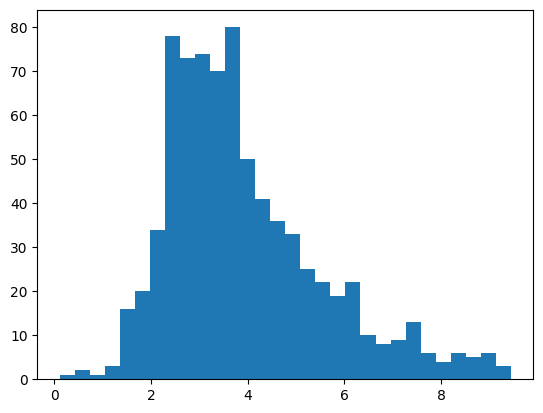

In [9]:
plt.hist(y_data, bins=30);

Теперь будем уже предсказывать.

In [ ]:
!pip install sentence_transformers

In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [13]:
embs = model.encode(X_concat, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
embs.shape

(770, 384)

In [49]:
emb_dim = 384
hid_dim = 10

regressor = nn.Sequential(
    nn.Linear(emb_dim, hid_dim),
    nn.ReLU(),
    nn.Linear(hid_dim, 1)
).cuda()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(regressor.parameters(),
                             lr=1e-3)

In [50]:
X_embs_train, X_embs_test, y_train, y_test = train_test_split(embs, y_data.values, train_size=0.8)

In [53]:
X_embs_train = torch.FloatTensor(X_embs_train).cuda()
X_embs_test = torch.FloatTensor(X_embs_test).cuda()
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

In [51]:
from tqdm.auto import tqdm
from IPython.display import clear_output

n_epochs = 2000
show_every = 20

train_losses = []
test_losses = []
i_start = 0

In [54]:
for i in tqdm(range(i_start, n_epochs)):
    regressor.train()
    optimizer.zero_grad()

    preds = regressor(X_embs_train).cpu().squeeze()
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    regressor.eval()
    with torch.no_grad():
        preds = regressor(X_embs_test).cpu().squeeze()
        loss = loss_fn(preds, y_test)
        test_losses.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

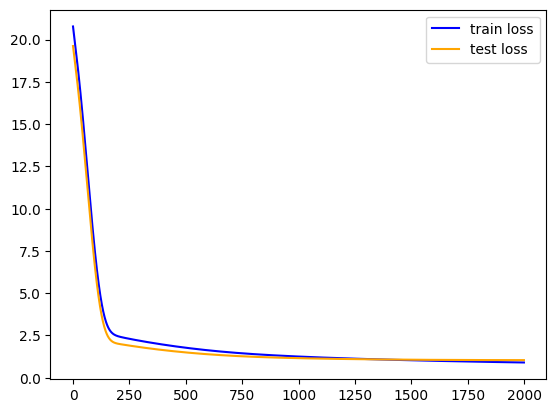

In [55]:
plt.plot(train_losses, color='blue', label='train loss')
plt.plot(test_losses, color='orange', label='test loss')
plt.legend()

**Вывод** MSE- ошибка около $2.3$, поэтому реальная ошибка может быть в $e^{\sqrt{2.3}} \approx 4.5$ раз.

Теперь предскажем на всех недостающий признак post valuation

In [56]:
X_data = table[text_columns]
X_concat = (X_data.iloc[:, 0].astype(str) + '; ' + X_data.iloc[:, 1].astype(str)).values

X_all_embs = torch.FloatTensor(model.encode(X_concat, batch_size=64, show_progress_bar=True)).cuda()

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

In [58]:
preds = regressor(X_all_embs).cpu().detach().squeeze().numpy()

In [61]:
table['predicted post valuation'] = np.exp(preds)

In [63]:
table[['predicted post valuation', 'Post Valuation']]

,predicted post valuation,Post Valuation
0,29.418037,14.83
1,8.696840,6.03
2,13.837018,NaN
3,3.108381,NaN
4,12.106389,4.62
...,...,...
1342,63.387295,NaN
1343,27.388449,NaN
1344,97.124390,65.00
1345,21.306845,NaN


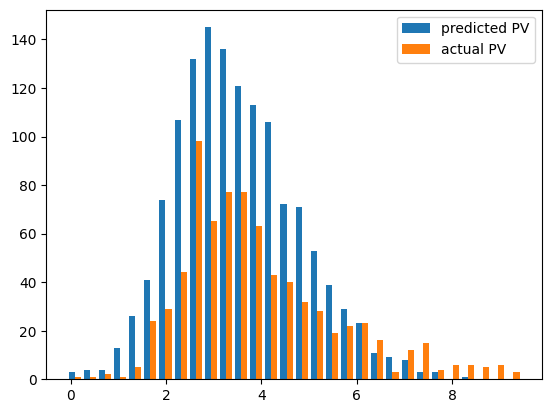

In [70]:
plt.hist(np.log(table[['predicted post valuation', 'Post Valuation']]), bins=30, label=['predicted PV', 'actual PV']);
plt.legend()